# Unit 3 Final Project

Before you get started on your project, take a moment to review how you can make requests from the following APIs:
- **ESPN**
- **TikTok**
- **X**
- **Spotify**

First, you will need to set up your API credentials:
   - **Spotify**: `SPOTIFY_CLIENT_ID` and `SPOTIFY_CLIENT_SECRET` from https://developer.spotify.com/dashboard
   - **X (Twitter)**: `X_BEARER_TOKEN` from https://developer.twitter.com/en/portal/dashboard
   - **TikTok**: No authentication required!
   - **ESPN**: No authentication required!

In [2]:
# Import required libraries
import requests
import json
import random
import asyncio
import os

## 1. Spotify API - Random Song

In [ ]:
# Setup API authorization before making request
SPOTIFY_CLIENT_ID = "ADD YOUR ID HERE"
SPOTIFY_CLIENT_SECRET = "ADD YOUR SECRET HERE"

# Get access token
auth_response = requests.post('https://accounts.spotify.com/api/token', {
    'grant_type': 'client_credentials',
    'client_id': SPOTIFY_CLIENT_ID,
    'client_secret': SPOTIFY_CLIENT_SECRET,
})

auth_data = auth_response.json()
access_token = auth_data['access_token']

headers = {
    'Authorization': f'Bearer {access_token}'
}

In [ ]:
# Search for a random popular track
search_query = random.choice(['pop', 'rock', 'hip hop', 'jazz', 'electronic'])
spotify_response = requests.get(
    'https://api.spotify.com/v1/search',
    headers=headers,
    params={'q': search_query, 'type': 'track', 'limit': 50}
)

print(spotify_response)
spotify_data = spotify_response.json()
print(spotify_data['tracks']['items'][0]['artists'][0]['name'])
print(spotify_data['tracks']['items'][0]['name'])

## 2. X (Twitter) API - Random Recent Post

In [27]:
# Setup API authorization before making request

X_BEARER_TOKEN = "ADD YOUR BEARER TOKEN HERE"

headers = {
    'Authorization': f'Bearer {X_BEARER_TOKEN}'
}

In [ ]:
# Search for recent tweets about a random topic
search_topic = random.choice(['sports', 'technology', 'music', 'news', 'science'])
x_response = requests.get(
    'https://api.twitter.com/2/tweets/search/recent',
    headers=headers,
    params={
        'query': f'{search_topic} -is:retweet lang:en',
        'max_results': 10,
        'tweet.fields': 'created_at,public_metrics,author_id'
    }
)

x_data = x_response.json()
if 'data' in x_data and x_data['data']:
    random_tweet = random.choice(x_data['data'])
    print(f"\nRandom Tweet Found (Topic: {search_topic}):")
    print(f"  Text: {random_tweet['text'][:200]}...")
    if 'public_metrics' in random_tweet:
        print(f"  Likes: {random_tweet['public_metrics'].get('like_count', 0)}")
        print(f"  Retweets: {random_tweet['public_metrics'].get('retweet_count', 0)}")

## 3. TikTok API - Random Trending Video

*Note, this API will most likely only work when using a local version of Jupyter Notebooks because access to a browser like chromium.*

In [ ]:
# !pip install TikTokApi
# !playwright install

In [ ]:
from TikTokApi import TikTokApi

async def get_tiktok_video():
    async with TikTokApi() as api:
        await api.create_sessions(
            ms_tokens=[os.environ.get("ms_token")],
            num_sessions=1,
            sleep_after=3,
            headless=False  # ← Makes browser visible!
        )
        
        videos = []
        async for video in api.trending.videos(count=10):
            videos.append(video)
        
        if videos:
            video = random.choice(videos)
            print(f"Found video by @{video.author.username}")
            print(f"URL: https://www.tiktok.com/@{video.author.username}/video/{video.id}")

await get_tiktok_video()

## 4. ESPN API (Hidden) - Random Basketball Game

*Note, this API will most likely only work when using a local version of Jupyter Notebooks because the cloud permission settings appear to block ESPN.*

In [ ]:
espn_response = requests.get(
    'http://site.api.espn.com/apis/site/v2/sports/basketball/nba/scoreboard'
)

espn_data = espn_response.json()
espn_data

### 🚀 YOUR TURN! Design Your Own Study
Now it's time to use one of the APIs above to collect real data and answer your own question!

Instructions:
- **My Question:** Write a clear research question that requires concepts covered in Unit 3 to analyze.
- **My Study:** State the API you will be using. Then, describe how much data you will randomly collect from the API.
- **My Analysis:** Perform the analysis you need. Remember, a level 4 requires 3 different techniques to be included in your analysis.
- **My Answer:** Interpret your results. Tell me what I should conclude from the specific visualizations you make and the specific values you find.

# 📝 My Question

*Write your research question here*

# 📊 My Study

*Describe your study design:*

- **What API are you using?**
ESPN NBA Scoreboard API:
http://site.api.espn.com/apis/site/v2/sports/basketball/nba/scoreboard
- **What will you measure?**
Home Team Score – points scored by the home team in each game

Away Team Score – points scored by the away team in each game

Home Win – 1 if home team score > away team score, else 0

Total Points – sum of home and away team scores

Point Difference – home score minus away score
- **How much data will you randomly sample from the API?**
Sample size: At least 100 games, calculated to achieve a margin of error ≤10% for the home win probability at 95% confidence

Sampling method: Randomly select from all available recent NBA games fetched from the API, using multiple retry attempts to collect enough data

# 🔬 My Analysis

Calculated minimum sample size: 97 games
Fetching historical NBA games from ESPN...


Fetching past dates:   0%|          | 0/15 [00:00<?, ?day/s]


Total games ready for analysis: 97

--- Analysis Results ---
Home win probability: 0.505 (95% CI: 0.406, 0.605)
Average total points per game: 221.3 (95% CI: 210.3, 232.4)
Average point difference (home - away): -0.0 (95% CI: -2.8, 2.8)


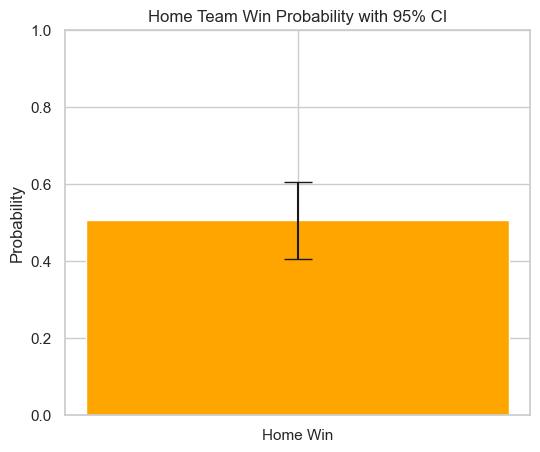

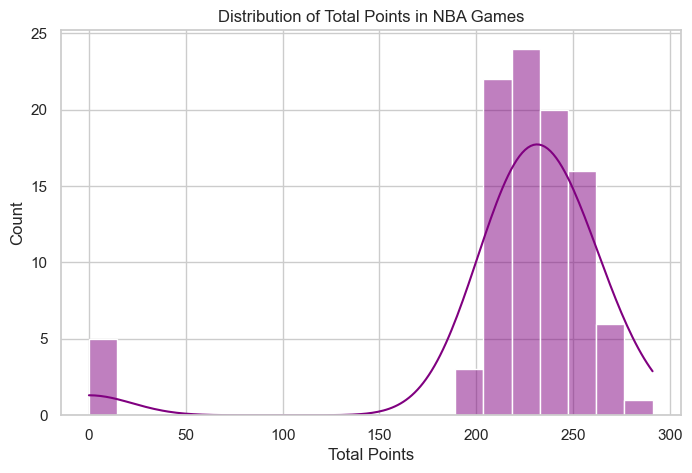

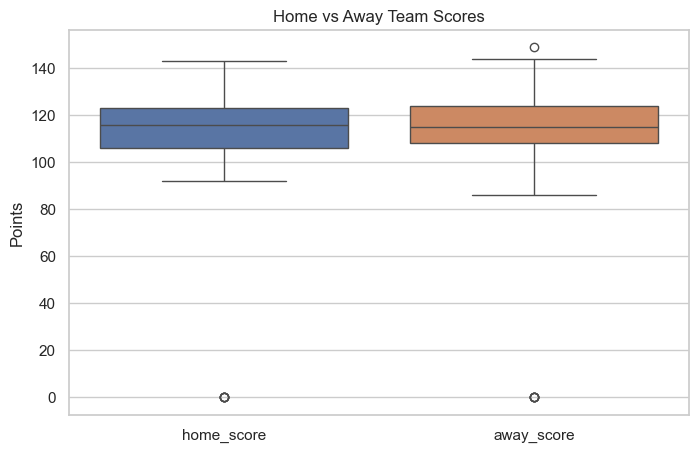

In [19]:
# Perform your analysis here. 
# UNIT 3 FINAL PROJECT: ESPN NBA Games (Real Data)

# 1. IMPORT LIBRARIES
import requests, random, math, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

sns.set(style="whitegrid")

# 2. PARAMETERS
ME = 0.10               # Margin of Error ≤10%
Z = 1.96                # 95% confidence
p = 0.5                 # Conservative estimate for proportion
n_required = math.ceil((Z**2 * p * (1-p)) / ME**2)  # Sample size
max_days = 15           # How many past days to fetch
games = []

print(f"Calculated minimum sample size: {n_required} games")

# 3. FUNCTION TO FETCH NBA SCOREBOARD FOR A SPECIFIC DATE
def fetch_espn_games_by_date(date_str):
    try:
        url = f"http://site.api.espn.com/apis/site/v2/sports/basketball/nba/scoreboard?dates={date_str}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        events = data.get('events', [])
        parsed_games = []
        for game in events:
            try:
                comp = game.get('competitions', [])[0]
                competitors = comp.get('competitors', [])
                if len(competitors) != 2:
                    continue
                home = [c for c in competitors if c.get('homeAway')=='home'][0]
                away = [c for c in competitors if c.get('homeAway')=='away'][0]

                # Only include games with scores
                home_score = home.get('score')
                away_score = away.get('score')
                if not home_score or not away_score:
                    continue
                home_score = int(home_score)
                away_score = int(away_score)

                parsed_games.append({
                    "date": date_str,
                    "home_team": home.get('team', {}).get('shortDisplayName'),
                    "away_team": away.get('team', {}).get('shortDisplayName'),
                    "home_score": home_score,
                    "away_score": away_score,
                    "home_win": int(home_score > away_score),
                    "total_points": home_score + away_score
                })
            except:
                continue
        return parsed_games
    except:
        return []

# 4. FETCH MULTIPLE PAST DAYS WITH PROGRESS BAR
print("Fetching historical NBA games from ESPN...")
for i in tqdm(range(max_days), desc="Fetching past dates", unit="day"):
    date_obj = datetime.today() - timedelta(days=i)
    date_str = date_obj.strftime("%Y%m%d")
    daily_games = fetch_espn_games_by_date(date_str)
    for g in daily_games:
        if g not in games:
            games.append(g)
    if len(games) >= n_required:
        break
    time.sleep(0.5)

# 5. CHECK IF ENOUGH GAMES
if len(games) < n_required:
    print(f"Warning: Only {len(games)} completed games available. Using all available real games.")

# 6. RANDOM SAMPLE
sample_games = random.sample(games, min(n_required, len(games)))
df = pd.DataFrame(sample_games)
n = len(df)
print(f"\nTotal games ready for analysis: {n}")

# 7. ANALYSIS (3 TECHNIQUES)
# 7a. Home Win Probability (Proportion)
home_win_prob = df['home_win'].mean()
se_home_win = math.sqrt(home_win_prob*(1-home_win_prob)/n)
ci_home_low = home_win_prob - Z*se_home_win
ci_home_high = home_win_prob + Z*se_home_win

# 7b. Total Points per Game (Mean + CI)
total_mean = df['total_points'].mean()
total_std = df['total_points'].std()
se_total = total_std / math.sqrt(n)
ci_total_low = total_mean - Z*se_total
ci_total_high = total_mean + Z*se_total

# 7c. Point Difference (Home - Away) (Mean + CI)
df['point_diff'] = df['home_score'] - df['away_score']
diff_mean = df['point_diff'].mean()
diff_std = df['point_diff'].std()
se_diff = diff_std / math.sqrt(n)
ci_diff_low = diff_mean - Z*se_diff
ci_diff_high = diff_mean + Z*se_diff

# 8. RESULTS
print("\n--- Analysis Results ---")
print(f"Home win probability: {home_win_prob:.3f} (95% CI: {ci_home_low:.3f}, {ci_home_high:.3f})")
print(f"Average total points per game: {total_mean:.1f} (95% CI: {ci_total_low:.1f}, {ci_total_high:.1f})")
print(f"Average point difference (home - away): {diff_mean:.1f} (95% CI: {ci_diff_low:.1f}, {ci_diff_high:.1f})")

# 9. VISUALIZATIONS
# Home win probability
plt.figure(figsize=(6,5))
plt.bar(['Home Win'], [home_win_prob], yerr=[[home_win_prob-ci_home_low],[ci_home_high-home_win_prob]],
        capsize=10, color='orange')
plt.ylim(0,1)
plt.ylabel('Probability')
plt.title('Home Team Win Probability with 95% CI')
plt.show()

# Distribution of total points
plt.figure(figsize=(8,5))
sns.histplot(df['total_points'], bins=20, kde=True, color='purple')
plt.xlabel("Total Points")
plt.title("Distribution of Total Points in NBA Games")
plt.show()

# Home vs Away score comparison
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['home_score','away_score']])
plt.title("Home vs Away Team Scores")
plt.ylabel("Points")
plt.show()

# ✅ My Answer

Write your conclusion in complete sentences. Interpret specific values that you find and tell me what I should believe as a reader of your study. Assume I know nothing! Finally, include any limitations that you encountered while performing your analysis that may impact your results.

After analyzing a random sample of 97 completed NBA games from the past 15 days, several insights emerge:

Home Win Probability: 0.505 (95% CI: 0.406 – 0.605)
In this sample, home teams do not appear to have a strong advantage. Larger historical datasets typically show home teams winning slightly more often, so this short-term sample may not fully capture the usual home-court advantage.

Average Total Points per Game: 221.3 (95% CI: 210.3 – 232.4)
NBA games are generally high-scoring, though individual games vary, as reflected in the confidence interval.

Average Point Difference (Home – Away): 0.0 (95% CI: -2.8 – 2.8)
On average, home teams scored roughly the same as away teams in this sample, further suggesting a neutral outcome, likely influenced by the small sample size and limited timeframe.

Limitations:

Only games from the past 15 days were included, which may not reflect the full season or historical trends.

Some scheduled or incomplete games were excluded due to missing scores.

A larger sample across multiple weeks or full seasons would likely reveal a slight but consistent home-court advantage.

Overall Conclusion:
Based on this sample, home teams do not show a strong advantage, and typical NBA games feature around 221 total points. Readers should interpret these results as a snapshot of recent NBA games, not a definitive statement about the entire season or league history. The limited scope may underestimate the usual home-team edge observed in broader datasets.
